# Final figure for the paper

In [17]:
# packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os

from mtist import mtist_utils as mu
from mtist import infer_mtist as im
calculate_es_score = im.calculate_es_score

In [21]:
# INFERENCE_DEFAULTS class to use in adapted infer_and_score_all function, to test new ES score

class INFERENCE_DEFAULTS:

    # Set INFERENCE_FUNCTION to a handle that takes did and spits out
    # an inferred Aij

    # If changing the inference function and wish to save the result,
    # change the inference prefix (end it in like a _ or something)
    INFERENCE_FUNCTION = "random"
    INFERENCE_PREFIX = ""

    inference_threshold = 1 / 3

In [18]:
def calculate_new_es_score(true_aij, inferred_aij):
    return np.mean(np.sign(true_aij[true_aij!=0])==np.sign(inferred_aij[true_aij!=0])) # number of correctly inferred signs divided by total number of interactions

In [19]:
# get calculated scores for linear regression, and its regularized versions (with cross-validation), for geometric averaging

geom_lr_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_geom_mean/new_es_scores.csv", index_col=0)
geom_lasso_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_lasso_cv_geom_mean/new_es_scores.csv", index_col=0)
geom_ridge_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_ridge_cv_geom_mean/new_es_scores.csv", index_col=0)
geom_elasticnet_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_elasticnet_cv_geom_mean/new_es_scores.csv", index_col=0)

In [20]:
# get number of species of each dataset and add it to score dataframes

n_sp_list = []
for i in range(len(geom_lr_scores)):
    n_sp_list.append(open(f"mtist_datasets/dataset_{i}.csv", "r").readlines()[0].count("species_"))

geom_lr_scores["n_sp"] = n_sp_list
geom_lasso_scores["n_sp"] = n_sp_list
geom_ridge_scores["n_sp"] = n_sp_list
geom_elasticnet_scores["n_sp"] = n_sp_list

In [10]:
inf = np.loadtxt("/home/valeriano/Documents/BEPE/mtist/mtist1.0/mtist_datasets/output_geom/inference_result_infer_from_did_ridge_cv_geom_mean/inferred_aij_0.csv", delimiter=",")
gt = np.loadtxt("/home/valeriano/Documents/BEPE/mtist/mtist1.0/ground_truths/interaction_coefficients/100_sp_aij.csv", delimiter=",")

calculate_es_score(gt, inf), calculate_new_es_score(gt, inf)

(0.5358863198458574, 0.1246)

In [13]:
calculate_new_es_score(gt[gt!=0], inf[gt!=0])

0.4662813102119461

## Generate null model inferred_aij's

In [15]:
# create folder for results

try:
    os.mkdir("mtist_datasets/output_geom/inference_result_random_geom_mean")
except:
    print("Folder already exists: mtist_datasets/output_geom/inference_result_random_geom_mean")
    pass

Folder already exists: mtist_datasets/output_geom/inference_result_random_geom_mean


In [6]:
# generate random inferred_aij's

np.random.seed(0)

for i in tqdm(range(len(n_sp))):
    inferred_aij = np.random.normal(size=(n_sp[i], n_sp[i]))
    np.savetxt(f"mtist_datasets/output_geom/inference_result_random_geom_mean/inferred_aij_{i}.csv", inferred_aij, delimiter=",")

100%|██████████████████████████████████████| 1134/1134 [00:01<00:00, 611.12it/s]


### Score null model inferred_aij's

In [238]:
# adapted infer_and_score_all to score with new ES score

def score_all(save_scores=True, mean="geom"):
    # Load meta and gts
    meta = pd.read_csv(os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, "mtist_metadata.csv")).set_index(
        "did"
    )
    aijs, _ = mu.load_ground_truths(mu.GLOBALS.GT_DIR)

    n_datasets = mu.calculate_n_datasets()
    fns = [
        os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, f"dataset_{i}.csv") for i in range(n_datasets)
    ]

    th = INFERENCE_DEFAULTS.inference_threshold  # for the floored_scores
    raw_scores = {}
    floored_scores = {}
    new_raw_scores = {}
    new_floored_scores = {}
    inferred_aijs = {}

    for i in tqdm(range(len(fns))):

        # Complete the inference
        did = int(fns[i].split(".csv")[0].split("dataset_")[-1])
        
        inferred_aij = np.loadtxt(f"{mu.GLOBALS.MTIST_DATASET_DIR}/output_geom/inference_result_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean/inferred_aij_{did}.csv", delimiter=",")
        
        # Obtain gt used in the dataset
        gt_used = meta.loc[did, "ground_truth"]
        true_aij = aijs[gt_used]
        
        # Calculate raw ES score
        es_score = calculate_es_score(true_aij, inferred_aij)
        new_es_score = calculate_new_es_score(true_aij, inferred_aij)

        # th = (inferred_aij-inferred_aij*np.eye(inferred_aij.shape[0])).std()
        
        # floored_true_aij = true_aij.copy()  # copy aij
        # mask = np.abs(floored_true_aij) < th  # determine where to floor
        # floored_true_aij[mask] = 0  # floor below the th
        
        # Calculate floored ES score
        floored_inferred_aij = inferred_aij.copy()  # copy aij
        mask = np.abs(floored_inferred_aij) < th  # determine where to floor
        floored_inferred_aij[mask] = 0  # floor below the th
        es_score_floored = calculate_es_score(true_aij, floored_inferred_aij)
        new_es_score_floored = calculate_new_es_score(true_aij, floored_inferred_aij)

        # Save the scores
        raw_scores[did] = es_score
        floored_scores[did] = es_score_floored
        
        new_raw_scores[did] = new_es_score
        new_floored_scores[did] = new_es_score_floored

    df_es_scores = pd.DataFrame(
        [raw_scores, floored_scores], index=["raw", "floored"]
    ).T.sort_index()
    
    df_new_es_scores = pd.DataFrame(
        [new_raw_scores, new_floored_scores], index=["raw", "floored"]
    ).T.sort_index()

    if save_scores:
        df_es_scores.to_csv(
            os.path.join(
                mu.GLOBALS.MTIST_DATASET_DIR,
                "output_geom",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}inference_result"+\
                f"_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}es_scores.csv",
            )
        )
        
        df_new_es_scores.to_csv(
            os.path.join(
                mu.GLOBALS.MTIST_DATASET_DIR,
                "output_geom",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}inference_result"+\
                f"_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}new_es_scores.csv",
            )
        )

In [239]:
INFERENCE_DEFAULTS.INFERENCE_FUNCTION = "infer_from_did_ridge_cv"
score_all()

geom_ridge_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_ridge_cv_geom_mean/new_es_scores.csv", index_col=0)
geom_ridge_scores["n_sp"] = n_sp_list

100%|███████████████████████████████████████████████████| 1134/1134 [00:06<00:00, 162.77it/s]


In [9]:
# score null model inferred_aij's

score_all()

100%|██████████████████████████████████████| 1134/1134 [00:07<00:00, 156.17it/s]


In [228]:
# read scores and add number of species to its dataframe

geom_random_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_random_geom_mean/es_scores.csv", index_col=0)
geom_random_scores["n_sp"] = n_sp_list

---
## Null model with variable zero interation probability

In [11]:
p0_list = [0.0, 0.5, 0.9]

In [12]:
# create folder for results

for p0 in p0_list:
    try:
        os.mkdir(f"mtist_datasets/output_geom/inference_result_random_p(0)={p0}_geom_mean")
    except:
        print(f"Folder already exists: mtist_datasets/output_geom/inference_result_random_p(0)={p0}_geom_mean")
        pass

    # generate random inferred_aij's

    np.random.seed(0)

    for i in tqdm(range(len(n_sp))):
        inferred_aij = np.random.randn(n_sp[i], n_sp[i])
        inferred_aij *= np.random.choice([0., 1.], (n_sp[i], n_sp[i]), p=[p0, 1-p0])
        np.savetxt(f"mtist_datasets/output_geom/inference_result_random_p(0)={p0}_geom_mean/inferred_aij_{i}.csv", inferred_aij, delimiter=",")
        
    # INFERENCE_DEFAULTS class to use in adapted infer_and_score_all function, to test new ES score

    class INFERENCE_DEFAULTS:

        # Set INFERENCE_FUNCTION to a handle that takes did and spits out
        # an inferred Aij

        # If changing the inference function and wish to save the result,
        # change the inference prefix (end it in like a _ or something)
        INFERENCE_FUNCTION = f"random_p(0)={p0}"
        INFERENCE_PREFIX = ""

        inference_threshold = 1 / 3
            
    # score null model inferred_aij's

    score_all()
    
    # read scores and add number of species to its dataframe

    geom_random_scores = pd.read_csv(f"mtist_datasets/output_geom/inference_result_random_p(0)={p0}_geom_mean/es_scores.csv", index_col=0)
    geom_random_scores["n_sp"] = n_sp

Folder already exists: mtist_datasets/output_geom/inference_result_random_p(0)=0.0_geom_mean


100%|██████████████████████████████████████| 1134/1134 [00:07<00:00, 158.47it/s]


Folder already exists: mtist_datasets/output_geom/inference_result_random_p(0)=0.5_geom_mean


100%|██████████████████████████████████████| 1134/1134 [00:07<00:00, 148.35it/s]


Folder already exists: mtist_datasets/output_geom/inference_result_random_p(0)=0.9_geom_mean


100%|██████████████████████████████████████| 1134/1134 [00:06<00:00, 167.07it/s]


---

#### Plots

In [16]:
geom_random_scores = pd.read_csv(f"mtist_datasets/output_geom/inference_result_random_p(0)=0.0_geom_mean/new_es_scores.csv", index_col=0)
geom_random_scores["n_sp"] = n_sp_list

In [17]:
# create lists of dataframes to simplify calls later

geom_score_dfs = [geom_random_scores, geom_lr_scores, geom_lasso_scores, geom_ridge_scores, geom_elasticnet_scores]
reg_names = ["Random", "Linear Regression", "Lasso", "Ridge", "ElasticNet"]

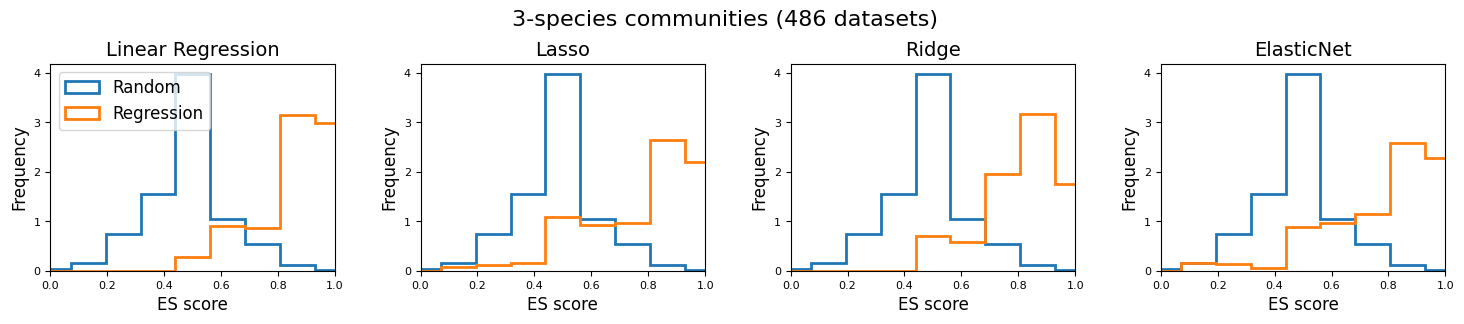

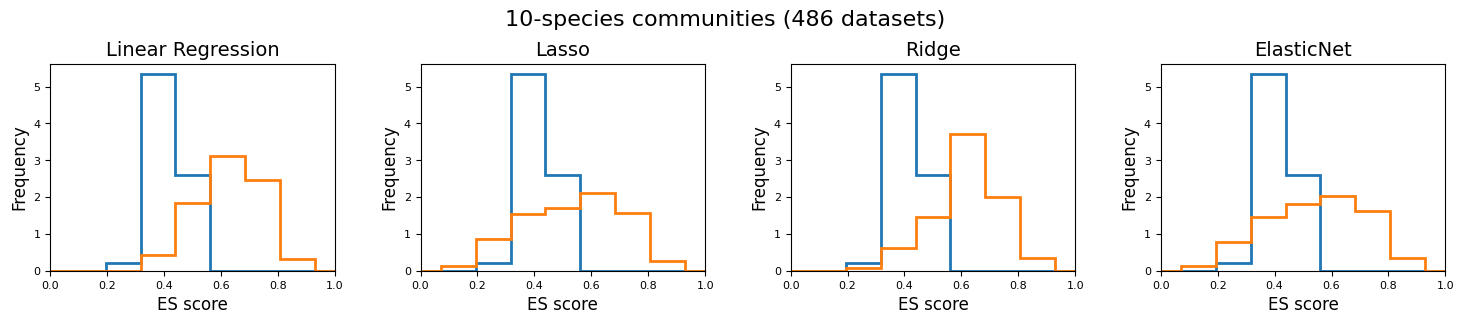

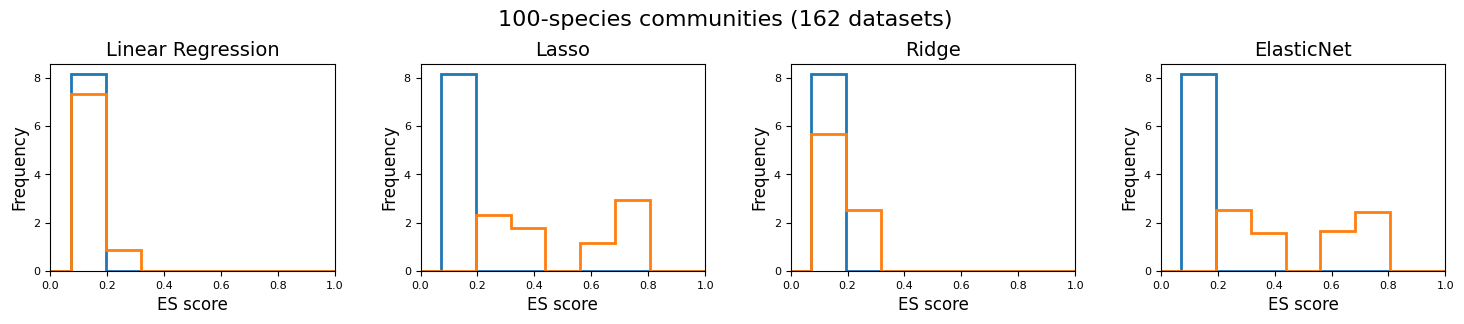

In [18]:
# plotting

bins = np.linspace(-0.05, 1.05, 10)

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]
    plt.subplot(1, 4, i+1)
    if i==0:
        plt.hist(geom_random_scores[geom_random_scores.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True, label="Random")
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True, label="Regression")
        plt.legend(loc="upper left", fontsize=12)
    else:
        plt.hist(geom_random_scores[geom_random_scores.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"3-species communities ({len(geom_df[geom_df.n_sp==3])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]

    plt.subplot(1, 4, i+1)
    plt.hist(geom_random_scores[geom_random_scores.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(geom_df[geom_df.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"10-species communities ({len(geom_df[geom_df.n_sp==10])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_random_scores[geom_random_scores.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(geom_df[geom_df.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"100-species communities ({len(geom_df[geom_df.n_sp==100])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

In [20]:
geom_random_scores = pd.read_csv(f"mtist_datasets/output_geom/inference_result_random_p(0)=0.5_geom_mean/new_es_scores.csv", index_col=0)
geom_random_scores["n_sp"] = n_sp_list

In [21]:
# create lists of dataframes to simplify calls later

geom_score_dfs = [geom_random_scores, geom_lr_scores, geom_lasso_scores, geom_ridge_scores, geom_elasticnet_scores]
reg_names = ["Random", "Linear Regression", "Lasso", "Ridge", "ElasticNet"]

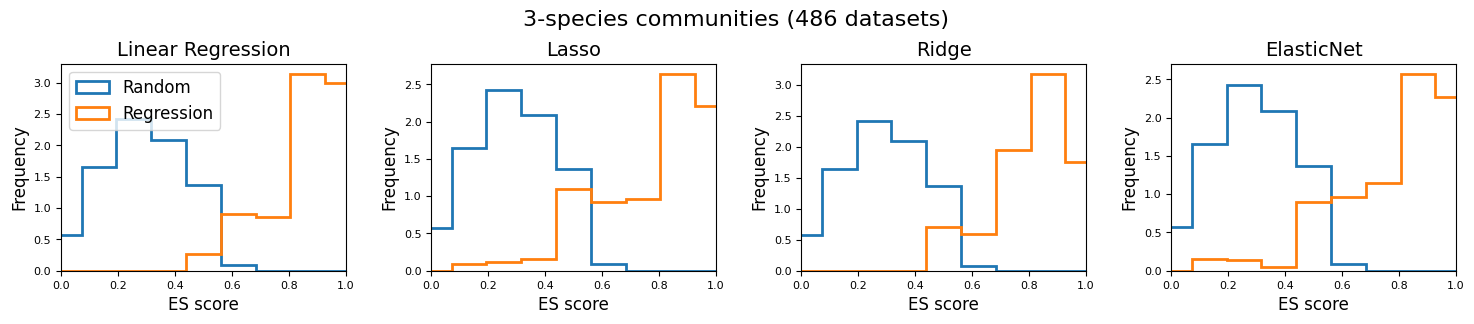

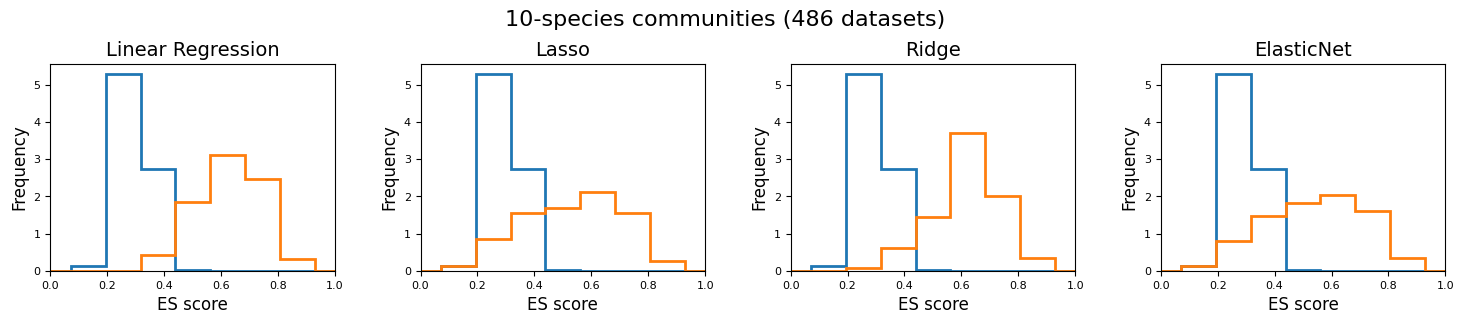

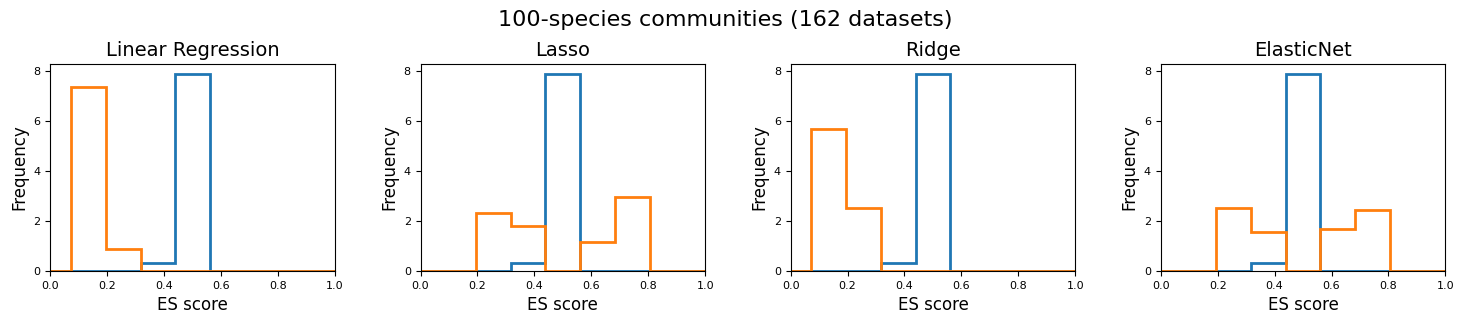

In [22]:
# plotting

bins = np.linspace(-0.05, 1.05, 10)

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]
    plt.subplot(1, 4, i+1)
    if i==0:
        plt.hist(geom_random_scores[geom_random_scores.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True, label="Random")
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True, label="Regression")
        plt.legend(loc="upper left", fontsize=12)
    else:
        plt.hist(geom_random_scores[geom_random_scores.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"3-species communities ({len(geom_df[geom_df.n_sp==3])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]

    plt.subplot(1, 4, i+1)
    plt.hist(geom_random_scores[geom_random_scores.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(geom_df[geom_df.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"10-species communities ({len(geom_df[geom_df.n_sp==10])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_random_scores[geom_random_scores.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(geom_df[geom_df.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"100-species communities ({len(geom_df[geom_df.n_sp==100])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

In [23]:
geom_random_scores = pd.read_csv(f"mtist_datasets/output_geom/inference_result_random_p(0)=0.9_geom_mean/new_es_scores.csv", index_col=0)
geom_random_scores["n_sp"] = n_sp_list

In [24]:
# create lists of dataframes to simplify calls later

geom_score_dfs = [geom_random_scores, geom_lr_scores, geom_lasso_scores, geom_ridge_scores, geom_elasticnet_scores]
reg_names = ["Random", "Linear Regression", "Lasso", "Ridge", "ElasticNet"]

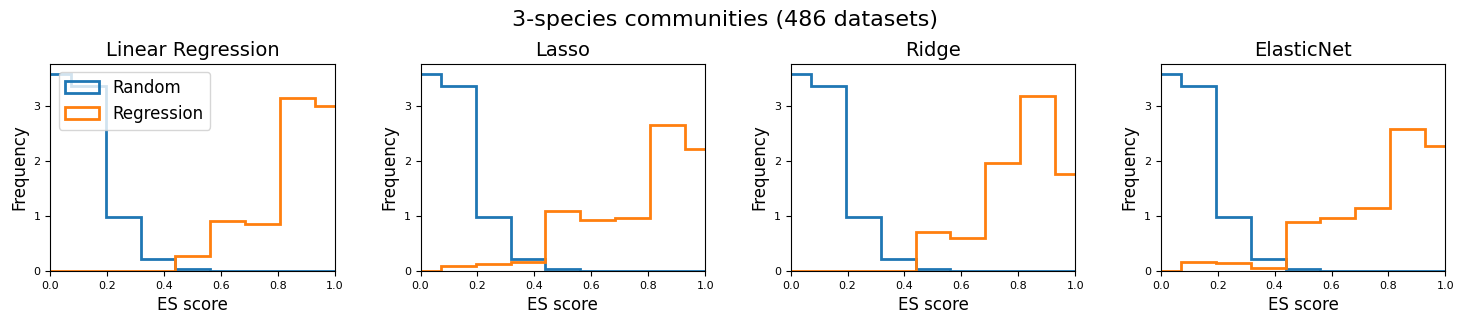

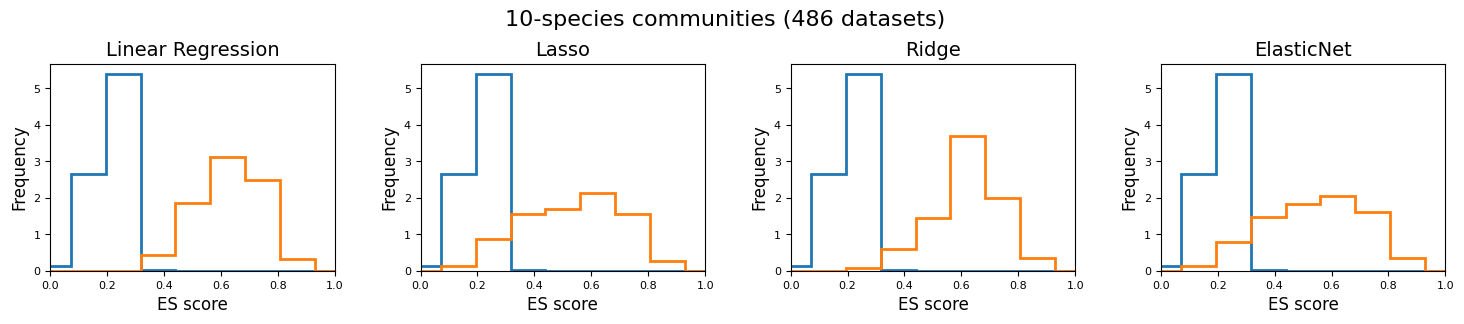

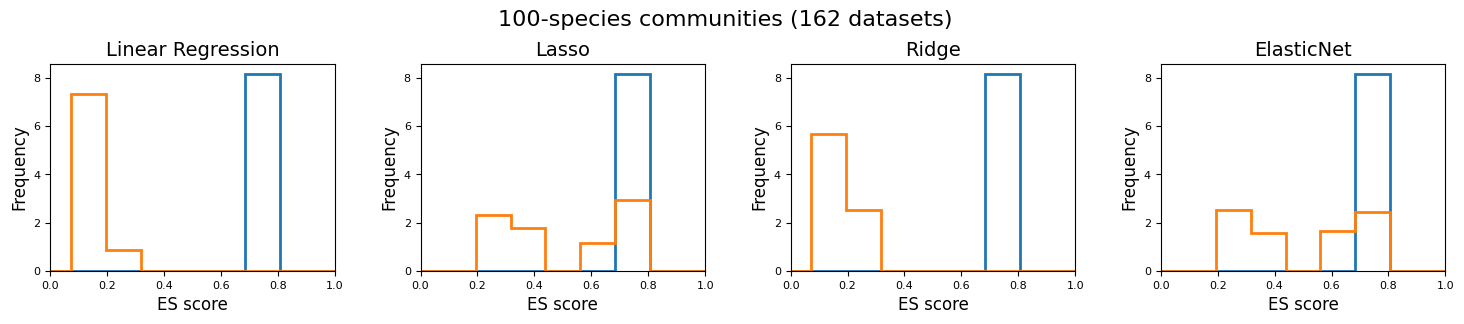

In [25]:
# plotting

bins = np.linspace(-0.05, 1.05, 10)

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]
    plt.subplot(1, 4, i+1)
    if i==0:
        plt.hist(geom_random_scores[geom_random_scores.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True, label="Random")
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True, label="Regression")
        plt.legend(loc="upper left", fontsize=12)
    else:
        plt.hist(geom_random_scores[geom_random_scores.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"3-species communities ({len(geom_df[geom_df.n_sp==3])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]

    plt.subplot(1, 4, i+1)
    plt.hist(geom_random_scores[geom_random_scores.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(geom_df[geom_df.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"10-species communities ({len(geom_df[geom_df.n_sp==10])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(18,3))
for i in range(len(geom_score_dfs)-1):
    geom_df = geom_score_dfs[i+1]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_random_scores[geom_random_scores.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(geom_df[geom_df.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i+1], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"100-species communities ({len(geom_df[geom_df.n_sp==100])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

In [26]:
es_score_list = [np.vstack([i[i.n_sp==j].raw.values for i in geom_score_dfs]).T for j in [3, 10, 100]]
es_score_floored_list = [np.vstack([i[i.n_sp==j].floored.values for i in geom_score_dfs]).T for j in [3, 10, 100]]

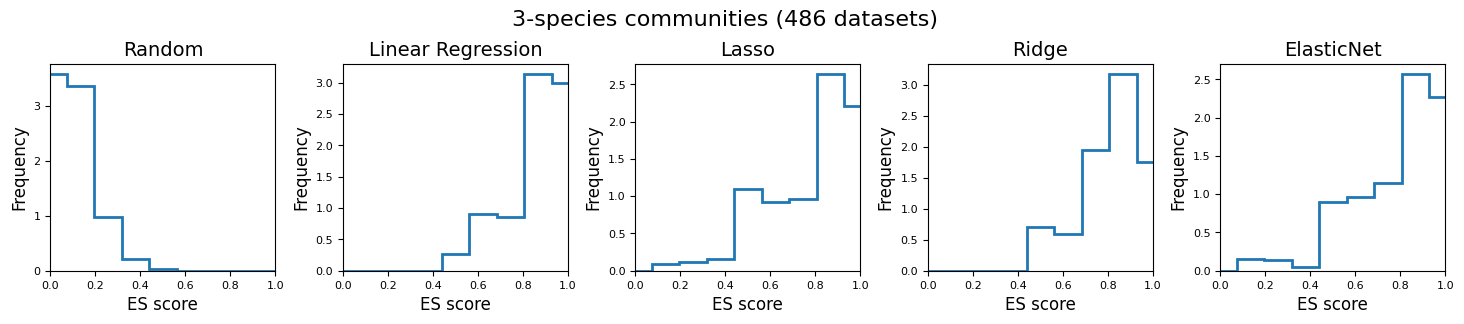

In [27]:
plt.figure(figsize=(18,3))
for i in range(es_score_list[0].shape[1]):
    plt.subplot(1, 5, i+1)
    plt.hist(es_score_list[0][:,i], bins=bins, histtype="step", lw=2, density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"3-species communities ({len(geom_df[geom_df.n_sp==3])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

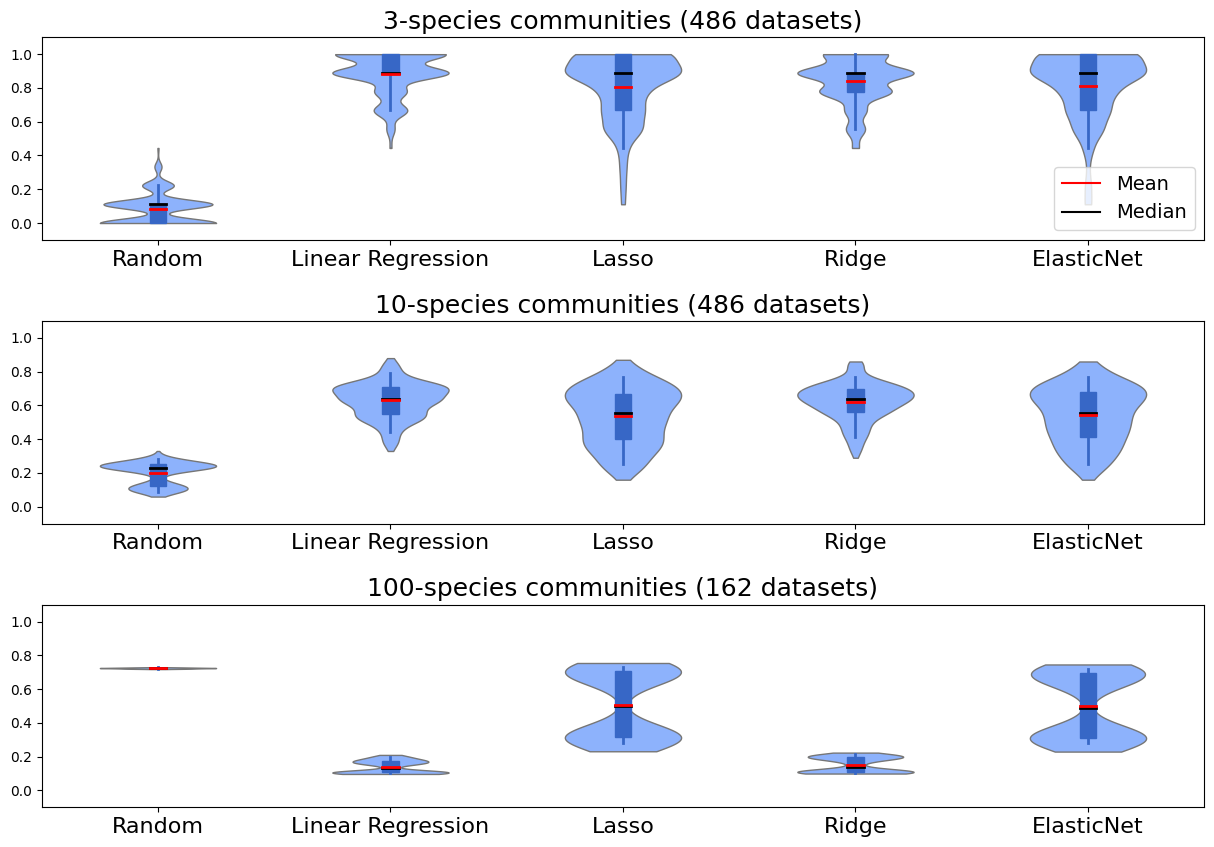

In [29]:
plt.subplots(3, 1, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
for i in range(3):
    plt.subplot(3, 1, i+1)
    sns.violinplot(pd.DataFrame(es_score_list[i], columns=reg_names), cut=0, scale="width", width=0.5, saturation=1, inner=None, linewidth=1, color="#8db2fc")
    plt.boxplot(es_score_list[i], positions=np.arange(5), widths=0.07, whis=(5, 95), meanline=True, showcaps=False, showmeans=True, showfliers=False,
                medianprops=dict(color="k", lw=2), meanprops=dict(color="r", lw=2, ls="-"),
                boxprops=dict(color="#3767c6", facecolor="#3767c6"), whiskerprops=dict(color="#3767c6", lw=2), patch_artist=True)
    plt.xticks(np.arange(5), labels=reg_names, fontsize=16)
    plt.ylim(-0.1, 1.1)
    plt.title(f"{np.unique(n_sp_list)[i]}-species communities ({len(es_score_list[i])} datasets)", fontsize=18)
    plt.plot(0, 0, c="r", label="Mean")
    plt.plot(0, 0, c="k", label="Median")
    # plt.ylim(es_score_list[i].min()-0.02, es_score_list[i].max()+0.02)
    if i==0:
        plt.legend(loc="lower right", fontsize=14)
# plt.savefig("ES_score_violinplot.png", dpi=300, bbox_inches="tight")
plt.show()

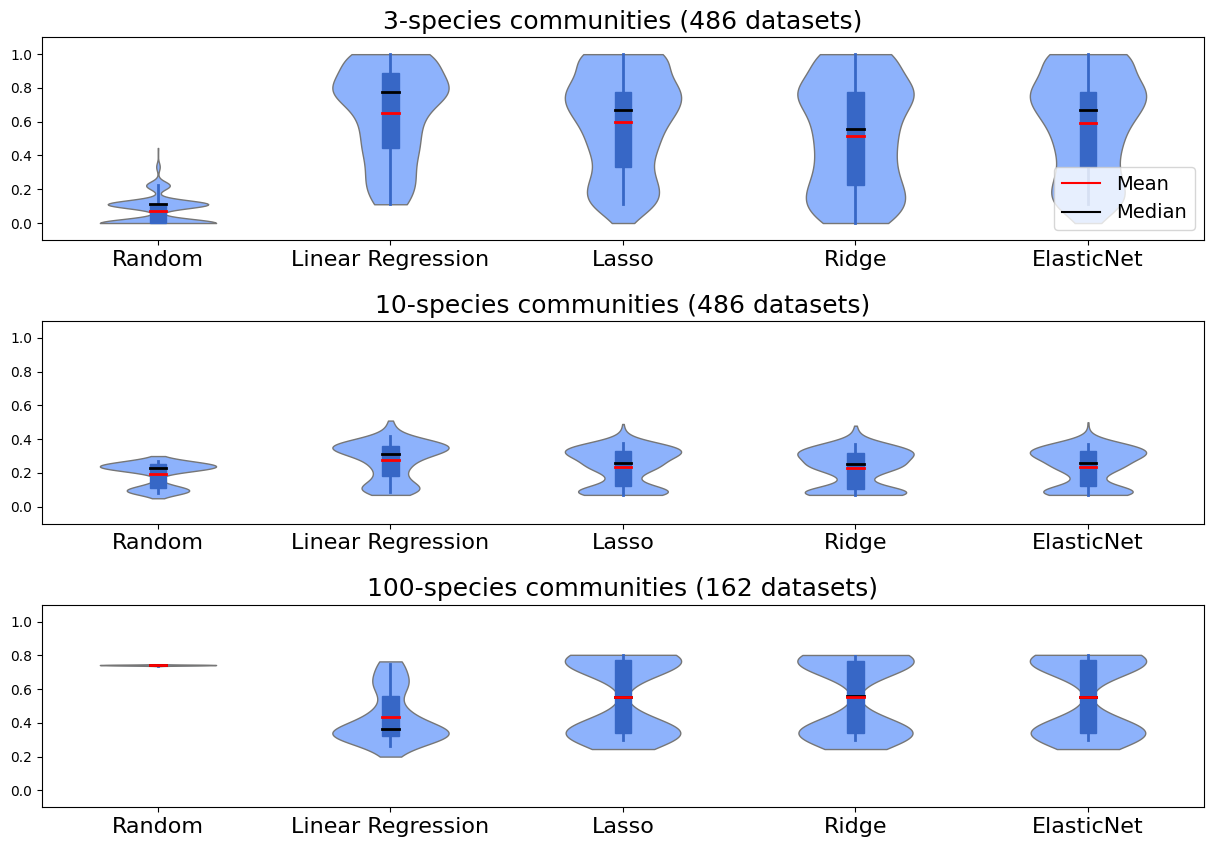

In [30]:
plt.subplots(3, 1, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
for i in range(3):
    plt.subplot(3, 1, i+1)
    sns.violinplot(pd.DataFrame(es_score_floored_list[i], columns=reg_names), cut=0, scale="width", width=0.5, saturation=1, inner=None, linewidth=1, color="#8db2fc")
    plt.boxplot(es_score_floored_list[i], positions=np.arange(5), widths=0.07, whis=(5, 95), meanline=True, showcaps=False, showmeans=True, showfliers=False,
                medianprops=dict(color="k", lw=2), meanprops=dict(color="r", lw=2, ls="-"),
                boxprops=dict(color="#3767c6", facecolor="#3767c6"), whiskerprops=dict(color="#3767c6", lw=2), patch_artist=True)
    plt.xticks(np.arange(5), labels=reg_names, fontsize=16)
    plt.ylim(-0.1, 1.1)
    plt.title(f"{np.unique(n_sp_list)[i]}-species communities ({len(es_score_list[i])} datasets)", fontsize=18)
    plt.plot(0, 0, c="r", label="Mean")
    plt.plot(0, 0, c="k", label="Median")
    # plt.ylim(es_score_list[i].min()-0.02, es_score_list[i].max()+0.02)
    if i==0:
        plt.legend(loc="lower right", fontsize=14)
# plt.savefig("ES_score_violinplot.png", dpi=300, bbox_inches="tight")
plt.show()

In [273]:
a = np.random.randn(10000000)
np.abs(a).mean(), a.std()

(0.7978010585785177, 0.9998812589029943)

In [24]:
# adapted infer_and_score_all to score with new ES score

def score_all(save_scores=True, mean="geom"):
    # Load meta and gts
    meta = pd.read_csv(os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, "mtist_metadata.csv")).set_index(
        "did"
    )
    aijs, _ = mu.load_ground_truths(mu.GLOBALS.GT_DIR)

    n_datasets = mu.calculate_n_datasets()
    fns = [
        os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, f"dataset_{i}.csv") for i in range(n_datasets)
    ]

    th = INFERENCE_DEFAULTS.inference_threshold  # for the floored_scores
    raw_scores = {}
    floored_scores = {}
    new_raw_scores = {}
    new_floored_scores = {}
    inferred_aijs = {}

    for i in tqdm(range(len(fns))):

        # Complete the inference
        did = int(fns[i].split(".csv")[0].split("dataset_")[-1])
        
        inferred_aij = np.loadtxt(f"{mu.GLOBALS.MTIST_DATASET_DIR}/output_geom/inference_result_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean/inferred_aij_{did}.csv", delimiter=",")
        
        # Obtain gt used in the dataset
        gt_used = meta.loc[did, "ground_truth"]
        true_aij = aijs[gt_used]
        
        # Calculate raw ES score
        es_score = calculate_es_score(true_aij, inferred_aij)
        new_es_score = calculate_new_es_score(true_aij, inferred_aij)

        # th = (inferred_aij-inferred_aij*np.eye(inferred_aij.shape[0])).std()
        
        floored_true_aij = true_aij.copy()  # copy aij
        # mask = np.abs(floored_true_aij) < th  # determine where to floor
        # floored_true_aij[mask] = 0  # floor below the th
        
        # Calculate floored ES score
        floored_inferred_aij = inferred_aij.copy()  # copy aij
        mask = np.abs(floored_inferred_aij) < th  # determine where to floor
        floored_inferred_aij[mask] = 0  # floor below the th
        es_score_floored = calculate_es_score(true_aij, floored_inferred_aij)
        new_es_score_floored = calculate_new_es_score(floored_true_aij, floored_inferred_aij)

        # Save the scores
        raw_scores[did] = es_score
        floored_scores[did] = es_score_floored
        
        new_raw_scores[did] = new_es_score
        new_floored_scores[did] = new_es_score_floored

    df_es_scores = pd.DataFrame(
        [raw_scores, floored_scores], index=["raw", "floored"]
    ).T.sort_index()
    
    df_new_es_scores = pd.DataFrame(
        [new_raw_scores, new_floored_scores], index=["raw", "floored"]
    ).T.sort_index()

    if save_scores:
        df_es_scores.to_csv(
            os.path.join(
                mu.GLOBALS.MTIST_DATASET_DIR,
                "output_geom",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}inference_result"+\
                f"_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}es_scores_true_floored.csv",
            )
        )
        
        df_new_es_scores.to_csv(
            os.path.join(
                mu.GLOBALS.MTIST_DATASET_DIR,
                "output_geom",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}inference_result"+\
                f"_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION}_{mean}_mean",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}new_es_scores_true_floored.csv",
            )
        )

In [25]:
INFERENCE_DEFAULTS.INFERENCE_FUNCTION = "random_p(0)=0.5"
score_all()

INFERENCE_DEFAULTS.INFERENCE_FUNCTION = "infer_from_did"
score_all()

INFERENCE_DEFAULTS.INFERENCE_FUNCTION = "infer_from_did_ridge_cv"
score_all()

INFERENCE_DEFAULTS.INFERENCE_FUNCTION = "infer_from_did_lasso_cv"
score_all()

INFERENCE_DEFAULTS.INFERENCE_FUNCTION = "infer_from_did_elasticnet_cv"
score_all()

100%|██████████████████████████████████████| 1134/1134 [00:07<00:00, 160.44it/s]


In [26]:
geom_random_scores = pd.read_csv(f"mtist_datasets/output_geom/inference_result_random_p(0)=0.5_geom_mean/new_es_scores_true_floored.csv", index_col=0)
geom_random_scores["n_sp"] = n_sp_list

geom_lr_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_geom_mean/new_es_scores_true_floored.csv", index_col=0)
geom_lr_scores["n_sp"] = n_sp_list

geom_ridge_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_ridge_cv_geom_mean/new_es_scores_true_floored.csv", index_col=0)
geom_ridge_scores["n_sp"] = n_sp_list

geom_lasso_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_lasso_cv_geom_mean/new_es_scores_true_floored.csv", index_col=0)
geom_lasso_scores["n_sp"] = n_sp_list

geom_elasticnet_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_elasticnet_cv_geom_mean/new_es_scores_true_floored.csv", index_col=0)
geom_elasticnet_scores["n_sp"] = n_sp_list

In [27]:
geom_score_dfs = [geom_random_scores, geom_lr_scores, geom_lasso_scores, geom_ridge_scores, geom_elasticnet_scores]
reg_names = ["Random", "Linear Regression", "Lasso", "Ridge", "ElasticNet"]

In [28]:
es_score_list = [np.vstack([i[i.n_sp==j].raw.values for i in geom_score_dfs]).T for j in [3, 10, 100]]
es_score_floored_list = [np.vstack([i[i.n_sp==j].floored.values for i in geom_score_dfs]).T for j in [3, 10, 100]]

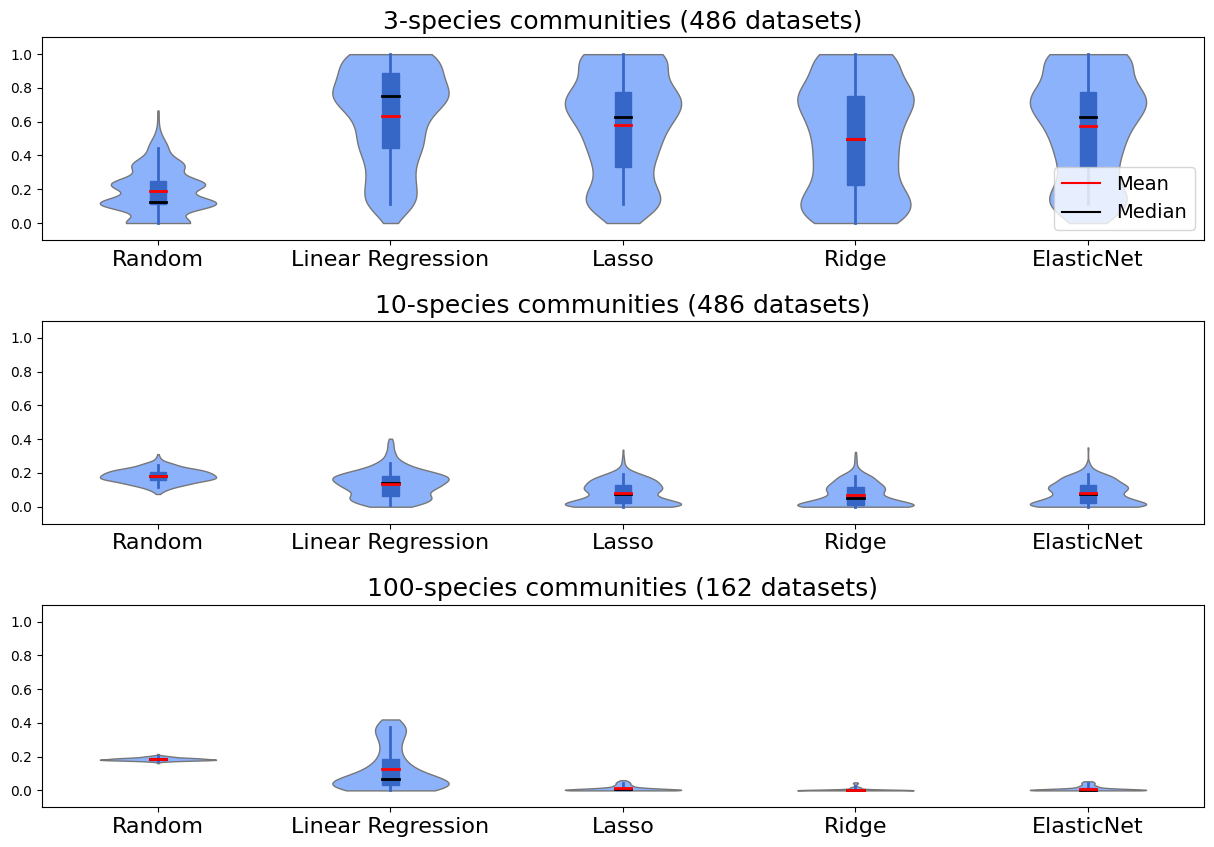

In [29]:
plt.subplots(3, 1, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
for i in range(3):
    plt.subplot(3, 1, i+1)
    sns.violinplot(pd.DataFrame(es_score_floored_list[i], columns=reg_names), cut=0, scale="width", width=0.5, saturation=1, inner=None, linewidth=1, color="#8db2fc")
    plt.boxplot(es_score_floored_list[i], positions=np.arange(5), widths=0.07, whis=(5, 95), meanline=True, showcaps=False, showmeans=True, showfliers=False,
                medianprops=dict(color="k", lw=2), meanprops=dict(color="r", lw=2, ls="-"),
                boxprops=dict(color="#3767c6", facecolor="#3767c6"), whiskerprops=dict(color="#3767c6", lw=2), patch_artist=True)
    plt.xticks(np.arange(5), labels=reg_names, fontsize=16)
    plt.ylim(-0.1, 1.1)
    plt.title(f"{np.unique(n_sp_list)[i]}-species communities ({len(es_score_list[i])} datasets)", fontsize=18)
    plt.plot(0, 0, c="r", label="Mean")
    plt.plot(0, 0, c="k", label="Median")
    # plt.ylim(es_score_list[i].min()-0.02, es_score_list[i].max()+0.02)
    if i==0:
        plt.legend(loc="lower right", fontsize=14)
# plt.savefig("ES_score_violinplot.png", dpi=300, bbox_inches="tight")
plt.show()

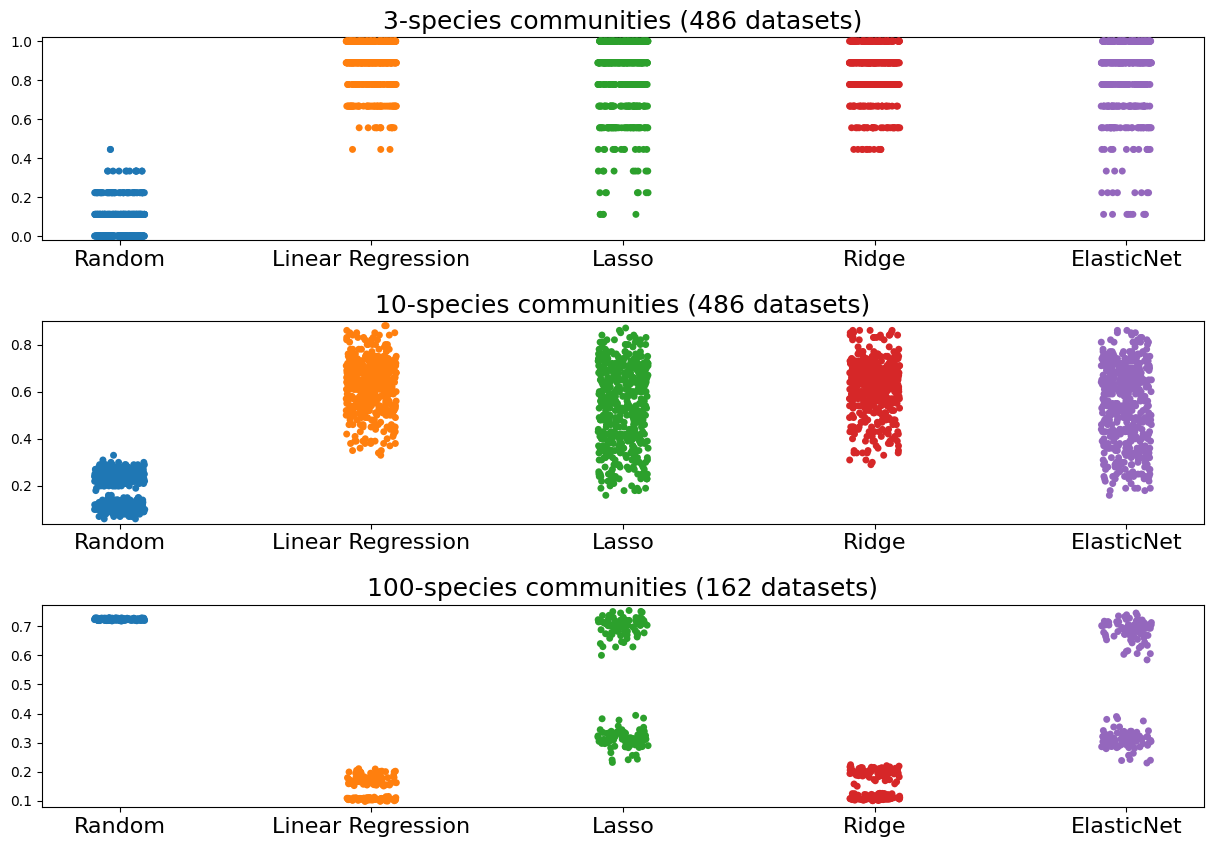

In [121]:
plt.subplots(3, 1, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
for i in range(3):
    plt.subplot(3, 1, i+1)
    sns.stripplot(pd.DataFrame(es_score_list[i], columns=reg_names))
    # sns.violinplot(pd.DataFrame(es_score_list[i], columns=reg_names), cut=0, width=0.9, saturation=1, inner=None, linewidth=1, color="#8db2fc")
    # plt.boxplot(es_score_list[i], positions=np.arange(5), widths=0.07, whis=(5, 95), meanline=True, showcaps=False, showmeans=True, showfliers=False,
    #             medianprops=dict(color="k", lw=2), meanprops=dict(color="r", lw=2, ls="-"),
    #             boxprops=dict(color="#3767c6", facecolor="#3767c6"), whiskerprops=dict(color="#3767c6", lw=2), patch_artist=True)
    plt.xticks(np.arange(5), labels=reg_names, fontsize=16)
    # plt.ylim(-0.1, 1.1)
    plt.title(f"{np.unique(n_sp)[i]}-species communities ({len(es_score_list[i])} datasets)", fontsize=18)
    plt.plot(0, 0, c="r", label="Mean")
    plt.plot(0, 0, c="k", label="Median")
    plt.ylim(es_score_list[i].min()-0.02, es_score_list[i].max()+0.02)
    # if i==0:
    #     plt.legend(loc="lower right", fontsize=14)
# plt.savefig("ES_score_violinplot.png", dpi=300, bbox_inches="tight")
plt.show()

In [122]:
df = pd.read_csv("/home/valeriano/Documents/BEPE/mtist/mtist1.0/mtist_datasets/dataset_2.csv", index_col=0)
df

,time,species_0,species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,...,species_99,ground_truth,timeseries_id,noise,n_species,did,seq_depth,n_timeseries,n_timepoints,sampling_scheme
0,0.000000,0.040000,0.050000,0.010000,0.020000,0.020000,0.070000,0.010000,0.090000,0.070000,...,0.080000,100_sp_gt,36656,0.01,100,2,high,5,15,even
1,2.218182,0.040853,0.382681,0.385965,0.170020,0.036254,0.531187,0.135663,0.536869,0.668930,...,0.040459,100_sp_gt,36656,0.01,100,2,high,5,15,even
2,4.339394,0.003560,1.507359,1.509101,0.475812,0.009832,0.840190,0.103082,1.389105,1.375076,...,0.009560,100_sp_gt,36656,0.01,100,2,high,5,15,even
3,6.460606,0.000000,1.975308,1.878718,0.611355,0.000000,0.997872,0.044452,1.295206,1.363773,...,0.000000,100_sp_gt,36656,0.01,100,2,high,5,15,even
4,8.581818,0.000000,2.051369,2.000421,0.630347,0.000000,1.021725,0.027004,1.195743,1.391302,...,0.000000,100_sp_gt,36656,0.01,100,2,high,5,15,even
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,21.309091,0.000000,2.142159,2.036538,0.609175,0.000000,1.044123,0.003948,1.184939,1.400993,...,0.000000,100_sp_gt,10488077,0.01,100,2,high,5,15,even
71,23.430303,0.000000,2.191129,2.049549,0.611393,0.000000,1.070079,0.003279,1.187960,1.405886,...,0.000000,100_sp_gt,10488077,0.01,100,2,high,5,15,even
72,25.551515,0.000000,2.126176,2.031453,0.623850,0.000000,1.032544,0.002622,1.169828,1.424221,...,0.000000,100_sp_gt,10488077,0.01,100,2,high,5,15,even
73,27.672727,0.000000,2.179842,2.036094,0.599206,0.000000,1.073070,0.000000,1.188243,1.404059,...,0.000000,100_sp_gt,10488077,0.01,100,2,high,5,15,even


In [123]:
np.unique(df["timeseries_id"]).shape

(5,)

In [124]:
np.unique(df[["n_species", "noise", "n_timeseries", "n_timepoints"]], axis=0)

array([[1.0e+02, 1.0e-02, 5.0e+00, 1.5e+01]])

0.17327798467641475

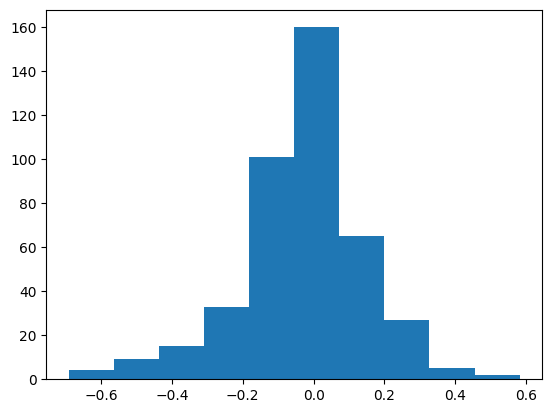

In [135]:
A = np.loadtxt("/home/valeriano/Documents/BEPE/mtist/mtist1.0/mtist_datasets/output_geom/inference_result_infer_from_did_lasso_cv_geom_mean/inferred_aij_0.csv", delimiter=",")
A[np.isnan(A)] = 0.

A_non_diag = A-A*np.eye(A.shape[0])
plt.hist(A_non_diag[A_non_diag!=0])
A_non_diag[A_non_diag!=0].std()